In [1]:
import time
import os, fnmatch
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from __future__ import print_function

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Conv2DTranspose, BatchNormalization, UpSampling2D, ZeroPadding2D
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU
import numpy.random as rand

/home/arjung2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# create a list, result, of all file names
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

result = find('*.jpg', 'lfwfaces')
print("Number of images: " + str(len(result)))
print("Example file name: " + result[0])

Number of images: 13233
Example file name: lfwfaces/Aaron_Eckhart_0001.jpg


In [3]:
x_train = []

for i in range(len(result)):
    img = load_img(result[0])
    img = img_to_array(img)
    img = (img - 127.5) / 127.5
    x_train.append(img)
    
x_train = np.array(x_train)
print(x_train.shape)

(13233, 250, 250, 3)


<class 'PIL.JpegImagePlugin.JpegImageFile'>


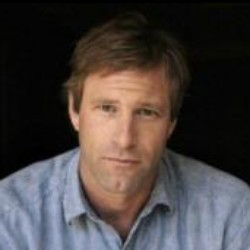

In [4]:
img = load_img(result[0])
print(type(img))
display(img)

In [5]:
# x_train = x_train[:1000]

def get_batch(size):
    
    arr = []
    
    for _ in range(size):
        
        k = rand.randint(0, 13233)
        arr.append(x_train[k])
    
    return np.array(arr)


In [6]:
# Generator

input_shape = (1, 1, 100)

generator = Sequential()

# conv2dTranspose layers to upsample
# generator.add(Conv2DTranspose(64,(5,5),strides=(2,2),activation='relu',input_shape=input_shape)) 
# generator.add(BatchNormalization())

# generator.add(Conv2DTranspose(128,(5,5),strides=(2,2),activation='relu',input_shape=input_shape)) 
# generator.add(BatchNormalization())

# generator.add(Conv2DTranspose(256,(5,5),strides=(2,2),activation='relu',input_shape=input_shape)) 
# generator.add(BatchNormalization())

# generator.add(Conv2DTranspose(3,(5,5),strides=(2,2),activation='relu',input_shape=input_shape))
# generator.add(BatchNormalization())

# --------------------------------------------------------------------------------------------------

generator.add(UpSampling2D(size=(5, 5), input_shape=input_shape)) # 100 x 5 x 5
generator.add(Conv2D(64,(5,5),activation='relu',padding='same')) # 64 x 5 x 5
# try adding strides=(2, 2)

generator.add(UpSampling2D(5)) # 64 x 25 x 25
generator.add(Conv2D(128,(5,5),activation='relu',padding='same')) # 128 x 25 x 25

generator.add(UpSampling2D(5)) # 128 x 125 x 125
generator.add(Conv2D(256,(5,5),activation='relu',padding='same')) # 256 x 125 x 125

generator.add(UpSampling2D(2)) # 256 x 250 x 250
generator.add(Conv2D(3,(5,5),activation='tanh',padding='same')) # 3 x 250 x 250

# changed kernal size from (2, 2) to (5, 5) for noisy instead of structured generation

# --------------------------------------------------------------------------------------------------



# goal = 3 x 250 x 250

# Discriminator

img_shape = (250, 250, 3)

discriminator = Sequential()

# --------------------------------------------------------------------------------------------------

# discriminator.add(Conv2D(64,(10,10),activation='relu',input_shape=img_shape)) # 64x241x241 --> 64x120x120
# discriminator.add(MaxPooling2D())
# # try changing MaxPooling2D to AveragePooling2D

# discriminator.add(Conv2D(128,(7,7),activation='relu', kernel_regularizer=l2(2e-4))) # 128x114x114 --> 128x57x57
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4))) # 256x54x54 --> 256x27x27 
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(512,(7,7),activation='relu',kernel_regularizer=l2(2e-4))) # 512x21x21 --> 512x10x10
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(1024,(10,10),activation='relu')) # 1024x1x1

# --------------------------------------------------------------------------------------------------

# discriminator.add(Conv2D(64,(3,3),activation='relu',input_shape=img_shape)) # 64x241x241 --> 64x120x120
# discriminator.add(MaxPooling2D())
# # try changing MaxPooling2D to AveragePooling2D

# discriminator.add(Conv2D(128,(4,4),activation='relu', kernel_regularizer=l2(2e-4))) # 128x114x114 --> 128x57x57
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(256,(5,5),activation='relu',kernel_regularizer=l2(2e-4))) # 256x54x54 --> 256x27x27 
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(512,(4,4),activation='relu',kernel_regularizer=l2(2e-4))) # 512x21x21 --> 512x10x10
# discriminator.add(MaxPooling2D())

# discriminator.add(Conv2D(1024,(3,3),activation='relu')) # 1024x1x1

# --------------------------------------------------------------------------------------------------

discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

# --------------------------------------------------------------------------------------------------

discriminator.add(Flatten()) # (None, 1024)

discriminator.add(Dense(1,activation="sigmoid",kernel_regularizer=l2(1e-3))) # (None, 1)

In [7]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 5, 5, 100)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          160064    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 125, 125, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 256)     819456    
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 250, 250, 256)     0         
__________

In [8]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 125, 125, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 125, 125, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
__________

In [9]:
# GAN

# initially -- since we only want to train either the generator or discriminator at a time
# discriminator.trainable = False

# gan input (noise) will be 100-dimensional vectors
gan_input = Input(shape=input_shape)

gan = Model(inputs = gan_input, outputs = discriminator(generator(gan_input)) )

gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001, beta_1=0.5))

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001, beta_1=0.5))



--------------- Epoch: 0 ---------------


/home/arjung2/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator loss: 0.07223292, GAN loss: 0.40543076

Discriminator loss: 0.03651881, GAN loss: 0.28725716

Discriminator loss: 0.029905941, GAN loss: 0.09346598

Discriminator loss: 0.013416618, GAN loss: 0.0686678

Discriminator loss: 0.008216902, GAN loss: 0.08543221

Discriminator loss: 0.0073937867, GAN loss: 0.032238446

Discriminator loss: 0.0051655783, GAN loss: 0.022993423

Discriminator loss: 0.0048982715, GAN loss: 0.037906077

Discriminator loss: 0.0052059772, GAN loss: 0.015428457

Loss History:


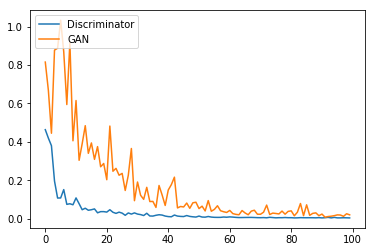

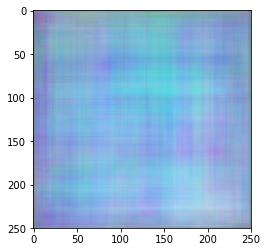

[0.00043125]


--------------- Epoch: 1 ---------------
Discriminator loss: 0.0033622342, GAN loss: 0.006308505

Discriminator loss: 0.0038844775, GAN loss: 0.011693214

Discriminator loss: 0.0031943037, GAN loss: 0.011219637

Discriminator loss: 0.0029475489, GAN loss: 0.013054337

Discriminator loss: 0.0028625159, GAN loss: 0.01126296

Discriminator loss: 0.0031347382, GAN loss: 0.014829725

Discriminator loss: 0.0027121683, GAN loss: 0.008459598

Discriminator loss: 0.0028889289, GAN loss: 0.00670252

Discriminator loss: 0.0025805659, GAN loss: 0.005529969

Loss History:


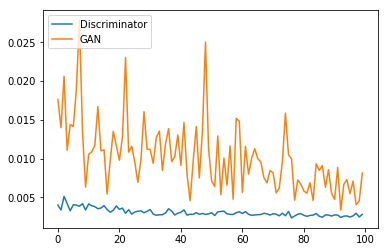

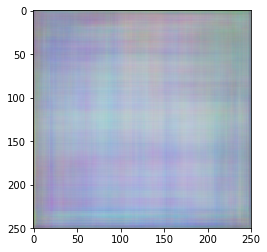

[0.00014165]


--------------- Epoch: 2 ---------------
Discriminator loss: 0.002532348, GAN loss: 0.006624681

Discriminator loss: 0.0024214147, GAN loss: 0.007713941

Discriminator loss: 0.0024480643, GAN loss: 0.0071189124

Discriminator loss: 0.0024547223, GAN loss: 0.0048524383

Discriminator loss: 0.002452498, GAN loss: 0.007867586

Discriminator loss: 0.0023697675, GAN loss: 0.0041502872

Discriminator loss: 0.0023136148, GAN loss: 0.004888177

Discriminator loss: 0.0022305856, GAN loss: 0.0058443537

Discriminator loss: 0.002504041, GAN loss: 0.0061997334

Loss History:


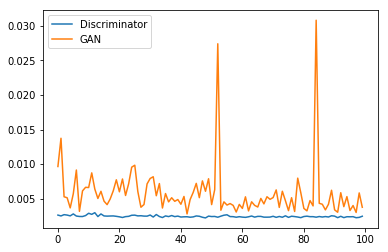

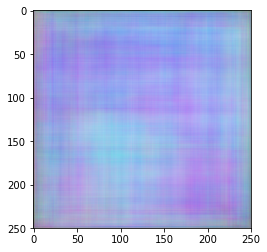

[2.5860329e-05]


--------------- Epoch: 3 ---------------
Discriminator loss: 0.0021933778, GAN loss: 0.0038658467

Discriminator loss: 0.002192062, GAN loss: 0.0037658298

Discriminator loss: 0.0022450956, GAN loss: 0.0031894632

Discriminator loss: 0.0021617129, GAN loss: 0.0041064783

Discriminator loss: 0.0022239434, GAN loss: 0.0027737196

Discriminator loss: 0.002145428, GAN loss: 0.0026586098

Discriminator loss: 0.0021909445, GAN loss: 0.0029705616

Discriminator loss: 0.0021769989, GAN loss: 0.005410811

Discriminator loss: 0.00216012, GAN loss: 0.0035234368

Loss History:


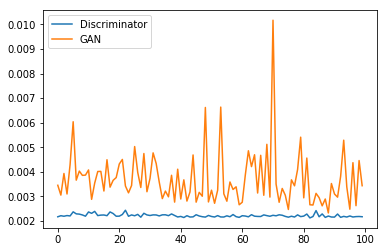

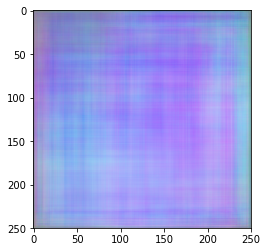

[8.888553e-06]


--------------- Epoch: 4 ---------------
Discriminator loss: 0.002204006, GAN loss: 0.0034221224

Discriminator loss: 0.0021374603, GAN loss: 0.0035576154

Discriminator loss: 0.0021295499, GAN loss: 0.0026616098

Discriminator loss: 0.002088621, GAN loss: 0.002736479

Discriminator loss: 0.002168541, GAN loss: 0.004192669

Discriminator loss: 0.0021206904, GAN loss: 0.0030851073

Discriminator loss: 0.0021588437, GAN loss: 0.0024111667

Discriminator loss: 0.0021484073, GAN loss: 0.0039850655

Discriminator loss: 0.002107781, GAN loss: 0.0031342679

Loss History:


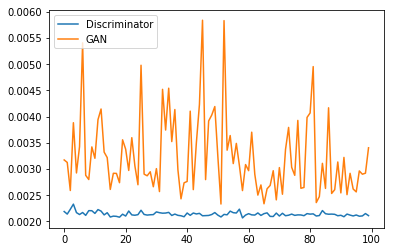

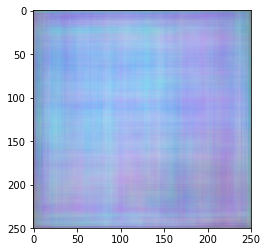

[7.002336e-06]


--------------- Epoch: 5 ---------------
Discriminator loss: 0.0020923694, GAN loss: 0.0025400587

Discriminator loss: 0.00211989, GAN loss: 0.0026331148

Discriminator loss: 0.002072017, GAN loss: 0.0023671791

Discriminator loss: 0.0020702765, GAN loss: 0.0024115113

Discriminator loss: 0.0020902432, GAN loss: 0.0023002012

Discriminator loss: 0.0020605363, GAN loss: 0.002391041

Discriminator loss: 0.0020644744, GAN loss: 0.002340834

Discriminator loss: 0.0020709324, GAN loss: 0.0028984447

Discriminator loss: 0.0020544203, GAN loss: 0.003468604

Loss History:


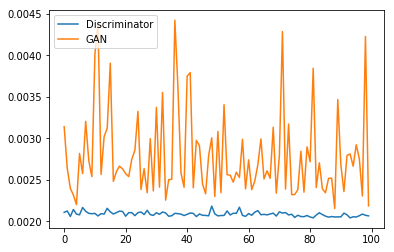

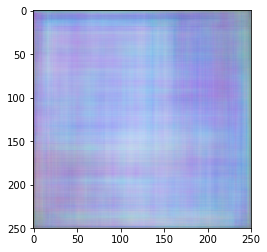

[4.5401084e-06]


--------------- Epoch: 6 ---------------
Discriminator loss: 0.002079691, GAN loss: 0.0022605592

Discriminator loss: 0.002052386, GAN loss: 0.002182542

Discriminator loss: 0.0020596925, GAN loss: 0.0026613558

Discriminator loss: 0.0020607703, GAN loss: 0.0044869897

Discriminator loss: 0.0020951661, GAN loss: 0.0028210224

Discriminator loss: 0.002060237, GAN loss: 0.0027330234

Discriminator loss: 0.0020503802, GAN loss: 0.002645149

Discriminator loss: 0.0020349487, GAN loss: 0.0022842642

Discriminator loss: 0.0020502557, GAN loss: 0.002432743

Loss History:


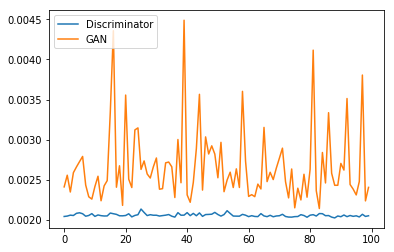

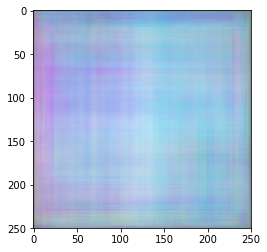

[3.1759891e-06]


--------------- Epoch: 7 ---------------
Discriminator loss: 0.0020802882, GAN loss: 0.002605128

Discriminator loss: 0.0020523225, GAN loss: 0.0022644368

Discriminator loss: 0.002042141, GAN loss: 0.0023603716

Discriminator loss: 0.002035682, GAN loss: 0.0022381581

Discriminator loss: 0.0020446843, GAN loss: 0.0024451327

Discriminator loss: 0.0020425075, GAN loss: 0.0024948576

Discriminator loss: 0.002025175, GAN loss: 0.0023930634

Discriminator loss: 0.0020432964, GAN loss: 0.0021987732

Discriminator loss: 0.0020301198, GAN loss: 0.0028237565

Loss History:


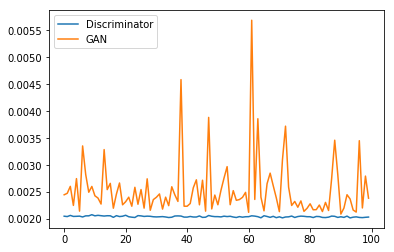

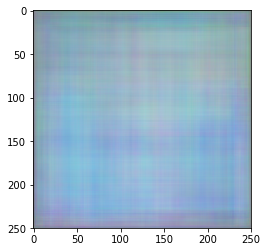

[4.515961e-06]


--------------- Epoch: 8 ---------------
Discriminator loss: 0.0020439283, GAN loss: 0.0022071064

Discriminator loss: 0.0020159867, GAN loss: 0.0021676652

Discriminator loss: 0.0020171164, GAN loss: 0.0020790624

Discriminator loss: 0.0020253295, GAN loss: 0.0021906255

Discriminator loss: 0.0020219753, GAN loss: 0.002511237

Discriminator loss: 0.0020170258, GAN loss: 0.003102168

Discriminator loss: 0.0020212063, GAN loss: 0.0022271306

Discriminator loss: 0.0020344148, GAN loss: 0.0021203314

Discriminator loss: 0.0020106211, GAN loss: 0.0023229686

Loss History:


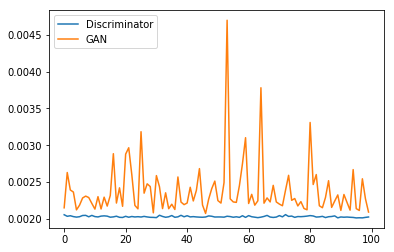

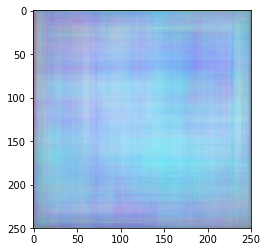

[1.4199823e-06]


--------------- Epoch: 9 ---------------
Discriminator loss: 0.0020290015, GAN loss: 0.0021664703

Discriminator loss: 0.002013743, GAN loss: 0.0024235775

Discriminator loss: 0.002033117, GAN loss: 0.0021078337

Discriminator loss: 0.0020110006, GAN loss: 0.0021156028

Discriminator loss: 0.002009311, GAN loss: 0.002364082

Discriminator loss: 0.0020053221, GAN loss: 0.0023382995

Discriminator loss: 0.0019962816, GAN loss: 0.0022017804

Discriminator loss: 0.0020089915, GAN loss: 0.003080927

Discriminator loss: 0.0020183644, GAN loss: 0.002084366

Loss History:


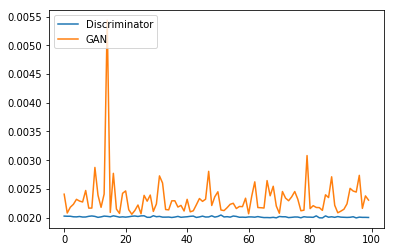

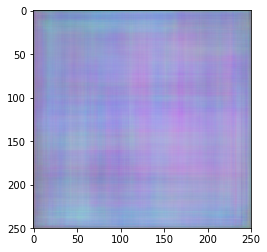

[2.2147144e-06]


--------------- Epoch: 10 ---------------
Discriminator loss: 0.0019959486, GAN loss: 0.00220328

Discriminator loss: 0.0020093713, GAN loss: 0.0021925957

Discriminator loss: 0.0020008674, GAN loss: 0.0022723034

Discriminator loss: 0.002009488, GAN loss: 0.00220775

Discriminator loss: 0.0019974988, GAN loss: 0.002447967

Discriminator loss: 0.0020124698, GAN loss: 0.0025295927

Discriminator loss: 0.0019988003, GAN loss: 0.002148155

Discriminator loss: 0.0019975451, GAN loss: 0.0021396086

Discriminator loss: 0.0019944683, GAN loss: 0.0030126108

Loss History:


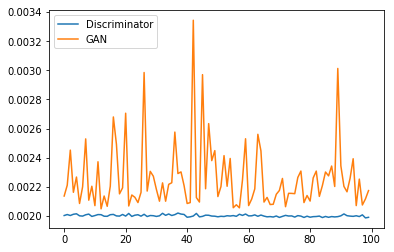

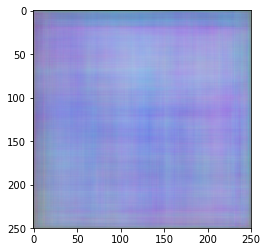

[1.5300972e-06]


--------------- Epoch: 11 ---------------
Discriminator loss: 0.0019855006, GAN loss: 0.002078618

Discriminator loss: 0.0019979759, GAN loss: 0.0020839942

Discriminator loss: 0.0019893616, GAN loss: 0.00212495

Discriminator loss: 0.00199293, GAN loss: 0.0021613743

Discriminator loss: 0.0019924538, GAN loss: 0.0023357342

Discriminator loss: 0.0019822274, GAN loss: 0.002383718

Discriminator loss: 0.0019853069, GAN loss: 0.0023442847

Discriminator loss: 0.0019859287, GAN loss: 0.0022046855

Discriminator loss: 0.0019802, GAN loss: 0.0021311305

Loss History:


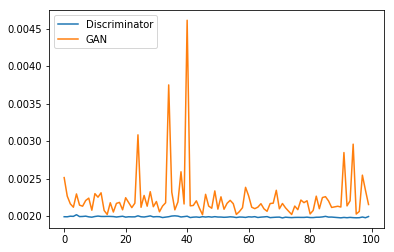

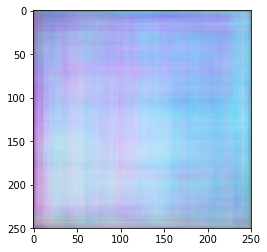

[7.0381077e-07]


--------------- Epoch: 12 ---------------
Discriminator loss: 0.0019775685, GAN loss: 0.002262519

Discriminator loss: 0.0019763361, GAN loss: 0.0020829474

Discriminator loss: 0.0019852694, GAN loss: 0.0020115795

Discriminator loss: 0.0019752532, GAN loss: 0.0023006536

Discriminator loss: 0.0019776567, GAN loss: 0.0021480885

Discriminator loss: 0.0019703193, GAN loss: 0.0019899104

Discriminator loss: 0.0019780232, GAN loss: 0.0020923933

Discriminator loss: 0.0019753089, GAN loss: 0.0020569558

Discriminator loss: 0.001965381, GAN loss: 0.00216993

Loss History:


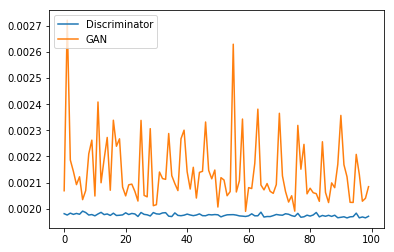

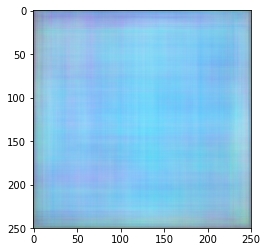

[4.252677e-07]


--------------- Epoch: 13 ---------------
Discriminator loss: 0.0019652937, GAN loss: 0.002019105

Discriminator loss: 0.0019663426, GAN loss: 0.0022008114

Discriminator loss: 0.0019677791, GAN loss: 0.0020272948

Discriminator loss: 0.0019662345, GAN loss: 0.002502621

Discriminator loss: 0.0019657311, GAN loss: 0.0023784002

Discriminator loss: 0.001963298, GAN loss: 0.0020457522

Discriminator loss: 0.0019615698, GAN loss: 0.0023956518

Discriminator loss: 0.0019595032, GAN loss: 0.0021438792

Discriminator loss: 0.0019558093, GAN loss: 0.002311425

Loss History:


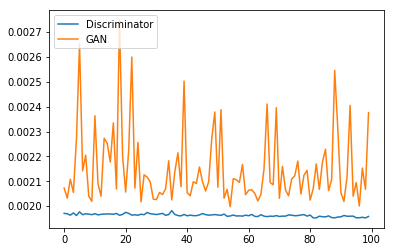

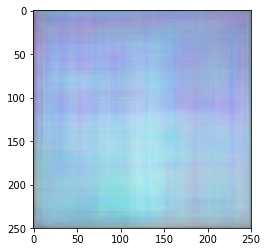

[5.688344e-07]


--------------- Epoch: 14 ---------------
Discriminator loss: 0.0019559439, GAN loss: 0.0022491592

Discriminator loss: 0.0019512695, GAN loss: 0.0021279103

Discriminator loss: 0.001951698, GAN loss: 0.0020604115

Discriminator loss: 0.0019493578, GAN loss: 0.0024810946

Discriminator loss: 0.0019594084, GAN loss: 0.0026409372

Discriminator loss: 0.0019486077, GAN loss: 0.0020498838

Discriminator loss: 0.0019431112, GAN loss: 0.001985683

Discriminator loss: 0.0019462429, GAN loss: 0.0020181013

Discriminator loss: 0.0019421213, GAN loss: 0.002144308

Loss History:


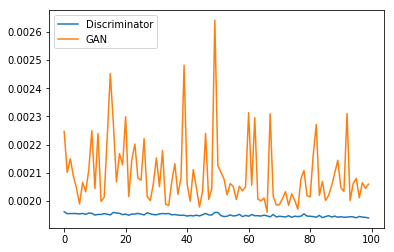

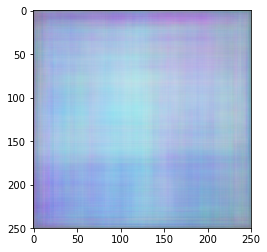

[5.9037495e-07]


--------------- Epoch: 15 ---------------
Discriminator loss: 0.0019376853, GAN loss: 0.0020003358

Discriminator loss: 0.0019370004, GAN loss: 0.00196622

Discriminator loss: 0.0019408844, GAN loss: 0.0021417586

Discriminator loss: 0.0019344619, GAN loss: 0.0022234446

Discriminator loss: 0.0019369589, GAN loss: 0.0020201681

Discriminator loss: 0.0019302411, GAN loss: 0.0021387055

Discriminator loss: 0.0019325758, GAN loss: 0.0020164903

Discriminator loss: 0.0019286152, GAN loss: 0.002039332

Discriminator loss: 0.0019289011, GAN loss: 0.0020603915

Loss History:


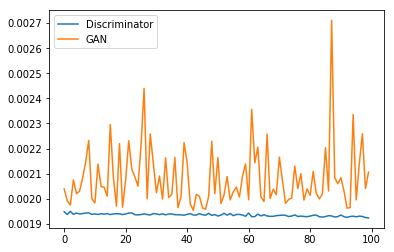

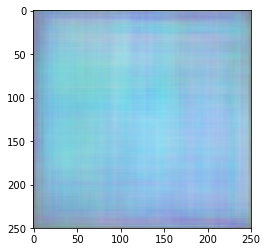

[4.978644e-07]


--------------- Epoch: 16 ---------------
Discriminator loss: 0.0019273633, GAN loss: 0.0031283293

Discriminator loss: 0.0019231596, GAN loss: 0.0021340377

Discriminator loss: 0.0019221712, GAN loss: 0.0020955822

Discriminator loss: 0.0019208237, GAN loss: 0.00200571

Discriminator loss: 0.0019179658, GAN loss: 0.0019768241

Discriminator loss: 0.001916281, GAN loss: 0.0019736164

Discriminator loss: 0.0019173343, GAN loss: 0.001990446

Discriminator loss: 0.00191573, GAN loss: 0.0019954303

Discriminator loss: 0.0019127665, GAN loss: 0.0019441536

Loss History:


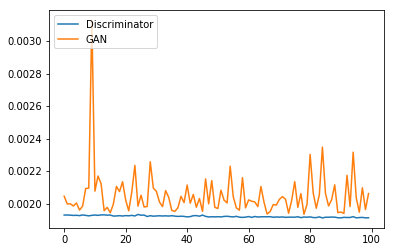

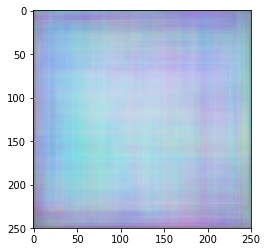

[4.515064e-07]


--------------- Epoch: 17 ---------------
Discriminator loss: 0.0019094237, GAN loss: 0.0020757767

Discriminator loss: 0.0019088507, GAN loss: 0.0019845245

Discriminator loss: 0.0019068219, GAN loss: 0.0020307594

Discriminator loss: 0.001907047, GAN loss: 0.0019515024

Discriminator loss: 0.0019053266, GAN loss: 0.0023855155

Discriminator loss: 0.0019011778, GAN loss: 0.0019867062

Discriminator loss: 0.0019032963, GAN loss: 0.0019664573

Discriminator loss: 0.0019019705, GAN loss: 0.0019491658

Discriminator loss: 0.0018987978, GAN loss: 0.0019832896

Loss History:


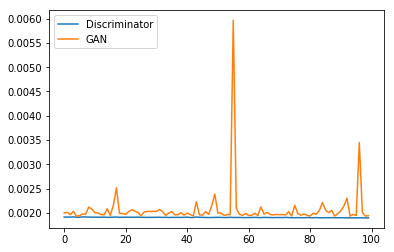

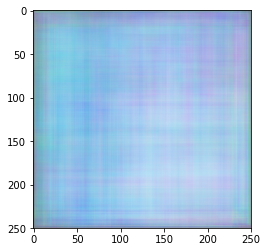

[2.9581503e-07]


--------------- Epoch: 18 ---------------
Discriminator loss: 0.0018914728, GAN loss: 0.0019787927

Discriminator loss: 0.0018966, GAN loss: 0.0019327529

Discriminator loss: 0.0018911265, GAN loss: 0.0024524846

Discriminator loss: 0.0018876193, GAN loss: 0.001960065

Discriminator loss: 0.0018858328, GAN loss: 0.0024433

Discriminator loss: 0.0018837602, GAN loss: 0.0019289058

Discriminator loss: 0.0018825583, GAN loss: 0.0019058876

Discriminator loss: 0.0018846325, GAN loss: 0.0018973242

Discriminator loss: 0.0018796636, GAN loss: 0.0019009943

Loss History:


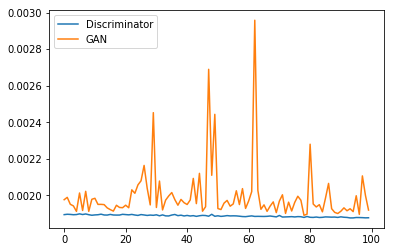

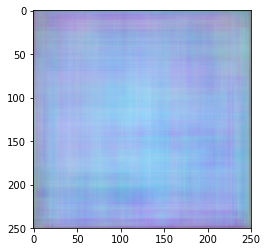

[3.266888e-07]


--------------- Epoch: 19 ---------------
Discriminator loss: 0.0018765847, GAN loss: 0.0020004506

Discriminator loss: 0.0018726744, GAN loss: 0.0019595136

Discriminator loss: 0.0018731385, GAN loss: 0.0021776701

Discriminator loss: 0.0018678992, GAN loss: 0.0019664266

Discriminator loss: 0.0018684557, GAN loss: 0.0019645542

Discriminator loss: 0.0018657496, GAN loss: 0.0019852417

Discriminator loss: 0.0018644249, GAN loss: 0.0020755793

Discriminator loss: 0.0018676854, GAN loss: 0.0018882361

Discriminator loss: 0.0018608711, GAN loss: 0.0020229446

Loss History:


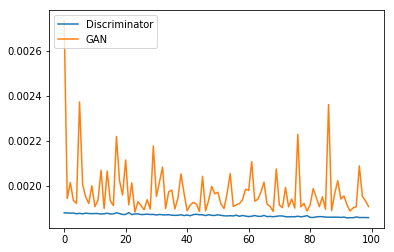

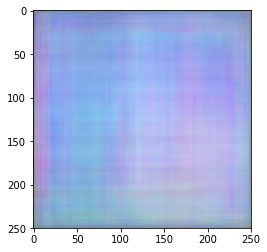

[2.962563e-07]


--------------- Epoch: 20 ---------------
Discriminator loss: 0.0018567786, GAN loss: 0.002068486

Discriminator loss: 0.0018571216, GAN loss: 0.0018920361

Discriminator loss: 0.0018545699, GAN loss: 0.002366104

Discriminator loss: 0.001850607, GAN loss: 0.0019096604

Discriminator loss: 0.0018471158, GAN loss: 0.0018757869

Discriminator loss: 0.00184448, GAN loss: 0.0019355679

Discriminator loss: 0.0018422828, GAN loss: 0.0018902622

Discriminator loss: 0.0018418605, GAN loss: 0.0021097492

Discriminator loss: 0.0018412606, GAN loss: 0.0023322997



KeyboardInterrupt: 

In [10]:
epochs = 30
batch_size = 10

for i in range(epochs):
    
    print("\n")
    print('-'*15, 'Epoch: ' + str(i), '-'*15)
    
    x_train_batch = get_batch(1000)
    # Number of batches
    batch_count = x_train_batch.shape[0] / batch_size
    
    start = 0
    end = batch_size
    
    d_loss = 0
    g_loss = 0
    g_loss_arr = []
    d_loss_arr = []
        
    for j in range(int(batch_count)):
        
        if j % 10 == 0 and j != 0:
            # print(".", end="")
            print("Discriminator loss: " + str(d_loss) + ", GAN loss: " + str(g_loss) + "\n")
        
        # Get a random set of input noise and images
        # generator.trainable = False
        noise = np.random.normal(0, 1, size=[batch_size, 1, 1, 100])        
        image_batch = x_train_batch[start:end]
        image_batch = np.reshape(image_batch, (batch_size, 250, 250, 3))
        
        # Generate fake images
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])

        # Labels for generated and real data
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 1

        # Train discriminator
        discriminator.trainable = True
        # discriminator.fit(X, y_dis, epochs=10)
        d_loss = discriminator.train_on_batch(X, y_dis)
        d_loss = discriminator.train_on_batch(X, y_dis)
        
        # d_history = discriminator.fit(X, y_dis)
        d_loss_arr.append(d_loss)

        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, 1, 1, 100])
        # The y-label will be 1 since we want to train the generator such that the GAN gives out 1
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        # g_loss = gan.train_on_batch(noise, y_gen)
        # g_history = gan.fit(noise, y_gen)
        g_loss_arr.append(g_loss)
        
        # Update start and end
        start += batch_size
        end += batch_size

    print("Loss History:")
    plt.plot(d_loss_arr, label = 'Discriminator')
    plt.plot(g_loss_arr, label = 'GAN')
    plt.legend(loc='upper left')
    plt.show()
    
    # Display a sample of the results
    examples = 1
    noise = np.random.normal(0, 1, size=[examples, 1, 1, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images * 0.5 + 0.5

    arr = discriminator.predict(generated_images)
    generated_images = generated_images.reshape(examples, 250, 250, 3)
    generated_images = np.clip(generated_images, 0, 1)

    for k in range(examples):
        # plt.imshow(generated_images[k], interpolation='nearest', cmap='gray_r')
        # plt.imshow(generated_images[k], interpolation='nearest')
        plt.imshow(generated_images[k], vmin=0, vmax=1)
        plt.show()
        print(arr[k])

In [ ]:
# # Display a sample of the results
# examples = 5
# noise = np.random.normal(0, 1, size=[examples, 1, 1, 100])
# generated_images = generator.predict(noise)
# generated_images = generated_images * 0.5 + 0.5
# plt.show()
# print(generated_images.shape)
# print(np.max(generated_images))
# arr = discriminator.predict(generated_images)
# generated_images = generated_images.reshape(examples, 250, 250, 3)
# generated_images = np.clip(generated_images, 0, 1)

# for k in range(examples):
#     # plt.imshow(generated_images[k], interpolation='nearest', cmap='gray_r')
#     # plt.imshow(generated_images[k], interpolation='nearest')
#     plt.imshow(generated_images[k], vmin=0, vmax=1)
#     plt.show()
#     print(arr[k])